# Bigram Model

In [ ]:
from huggingface_hub import notebook_login
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import random
from fastcore.all import *

%matplotlib inline

## Dataset generation

In [ ]:
names = urlopen("https://raw.githubusercontent.com/FinNLP/cities-list/master/list.txt").read().decode("utf-8").splitlines()
names = ["."+s.lower()+"." for s in names]

In [ ]:
names[:10]

['.aabenraa.',
 '.aach.',
 '.aachen.',
 '.aadorf.',
 '.aalborg.',
 '.aalburg.',
 '.aalen.',
 '.aalsmeer.',
 '.aalst.',
 '.aalten.']

## Training of bigram model

In [ ]:
vocab = "abcdefghijklmnopqrstuvwxyz."
vocab_size = len(vocab)
def tok_fn(s: str): return list(c for c in s)
tok2id = dict((c,i) for i, c in enumerate(vocab))
id2tok = dict((i,c) for i, c in enumerate(vocab))

In [ ]:
names = [name for name in names if all(c in vocab for c in name)]

In [ ]:
mat = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

In [ ]:
for name in names:
    for c, nc in zip(name, name[1:]): mat[tok2id[c]][tok2id[nc]] += 1

(-0.5, 26.5, 26.5, -0.5)

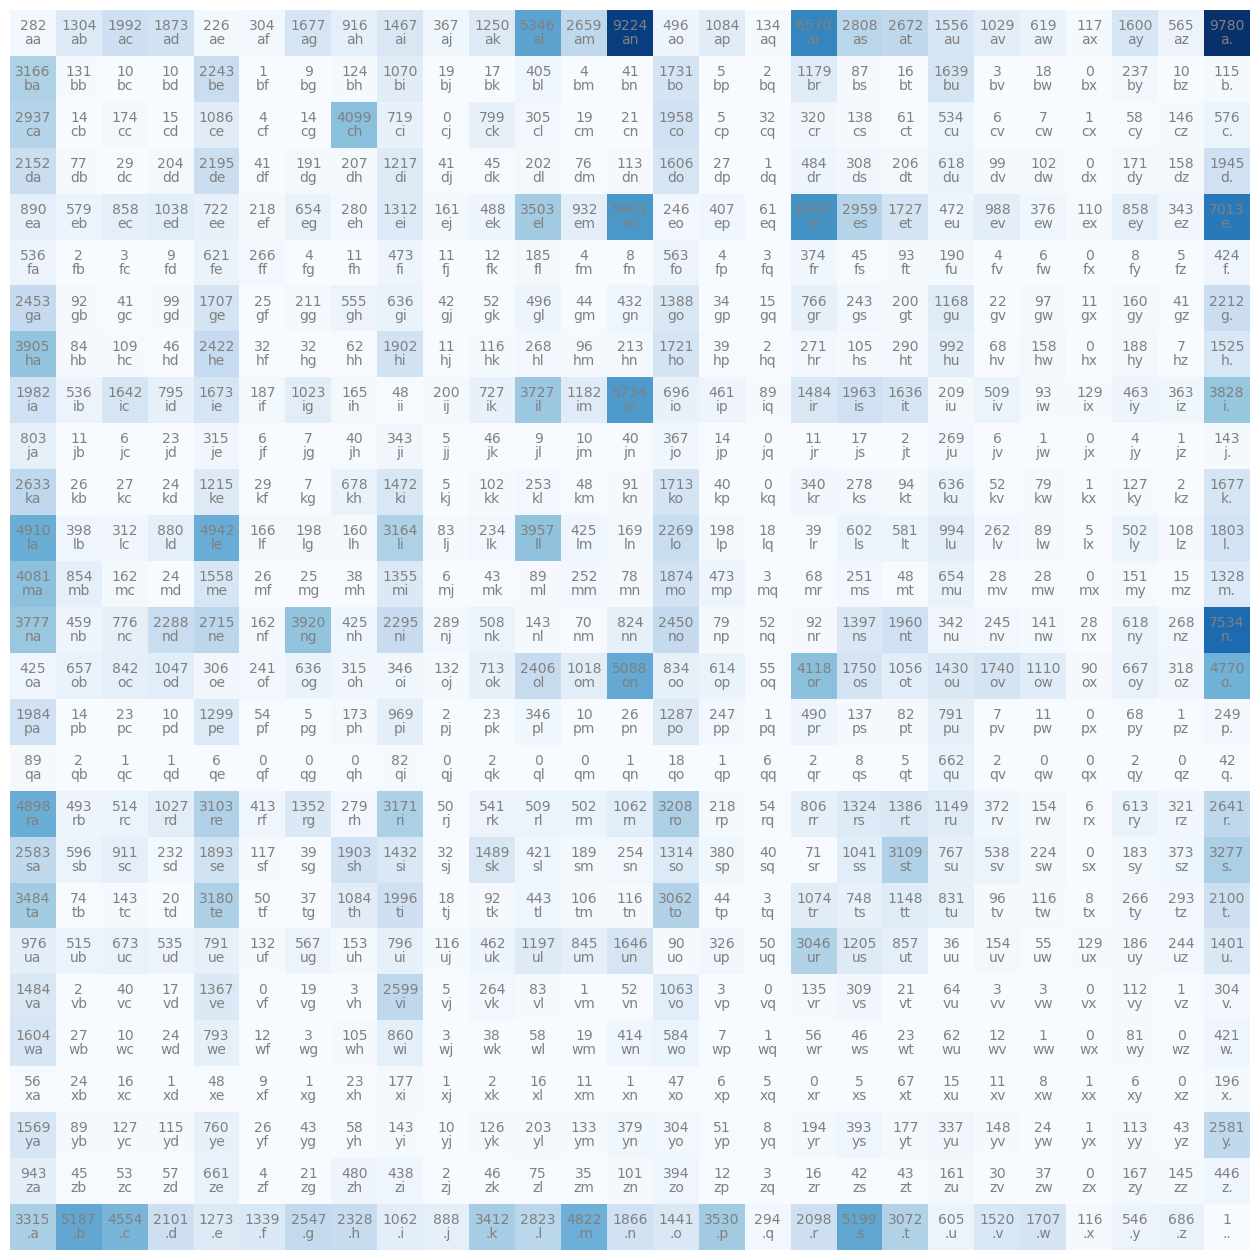

In [ ]:
plt.figure(figsize=(16, 20))
plt.imshow(mat, cmap="Blues")
for i in range(vocab_size):
    for j in range(vocab_size):
        ch_str =  id2tok[i]+id2tok[j]
        plt.text(j, i, mat[i][j].item(), color="gray", ha="center", va="bottom")
        plt.text(j, i, ch_str, color="gray", ha="center", va="top")
plt.axis("off")

Converting frequencies of the bigrams to probabilities. For each given char `c` we have an array of frequencies of the chars following it. We can convert this to a probability distribution where this array is converted to a distribution which tells whats the next most likely char given this char.

Text(0.5, 1.0, "id2tok[i]='k'")

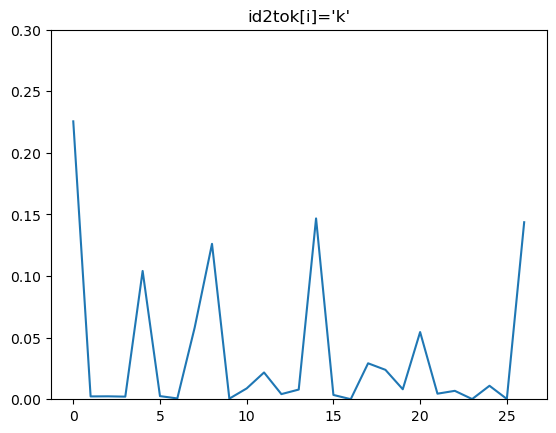

In [ ]:
N = mat + 1 # model smoothing
probs = N / N.sum(1, keepdim=True)
i = 10
plt.ylim(0, 0.3)
plt.plot(probs[i])
plt.title(f"{id2tok[i]=}")

## Bi-Gram Model

In [ ]:
g = torch.Generator().manual_seed(42)
for _ in range(20):
    i = tok2id["."]
    w = ""
    while True:
        w += id2tok[i]
        i = torch.multinomial(probs[i], num_samples=1, replacement=True, generator=g).item()
        if id2tok[i]==".": break
    print(w[1:])

bavienowiltanbajevagyontroonthmarier
puntidenamoa
baddovethant
daloydonglowa
heveraanorirzkhilawaijinia
baloru
benarik
bar
pudia
feryatehisinciav
mo
dworanaseterssan
kashyaminkonnagi
ldesenoimon
halagl
vidicharbupesackir
k
erauneller
brra
nesikamutrumbalelng


## Random Model

In [ ]:
g = torch.Generator().manual_seed(42)
for _ in range(20):
    i = tok2id["."]
    w = ""
    while True:
        w += id2tok[i]
        i = torch.multinomial(torch.ones(vocab_size), num_samples=1, replacement=True, generator=g).item()
        if id2tok[i]==".": break
    print(w[1:])

ykvhvfpwuqtagbcjrvfeygnvcoxntgmbzqhh
pgnxixmypmoafqkddvpethken
vayoydnkkpceshhcemmlanorirzkgcidwhijhfbd
bmdwkxjbkxuqikqenrtpuddaxfmryptwhlpdpcsavlmoodwsjhnzeztpvngaqkkjfxyaminkvinagtdlcjsepwihoalhplugl
vbdbcqbabupesacyxrmkderaunebnqf
brkapnubgkjjswrumglzfvnyvp
ubnfarw
rnzjphabdeurvnlpswezyyimtphpcauotmxlhnogvzddrfoeimoarvfifkpkjjgejsoechdqwstd
bhsuqmardakcorueb
rzhljiiozowzgkg
hymwlrodrhbixljha
ooitwjmhauazgotdyiidlrzhqbjbihegkhahx
keqjjugqmemfszhlyqvxgpaexoiggyzzvwhncutdf
errdaa
laqjeiuerguym
pmwiygfqhrclpufnxjjjopxfqubeyumrywuafxwfsasgjkboyncqxmgikonotlhgmjfqlkezxurmwhvlinkxpdaqcsbuuqfssu
z
pksbfshabhtroifdugmrqdat
tjk
qvdwkclgquyks


## Model Analysis

To calculate how good the model performs on a dataset, we can calculate its output probs on the dataset. How confident is the model in predicting the next token of the dataset? An ideal model could predict the with high probability the dataset, if it is trained from the same distribution. A bad model, will be less confident in predicting the dataset. Lets identify the model quality for the training data

In [ ]:
for w in names[:3]:
    for c, nc in zip(w, w[1:]):
        p = probs[tok2id[c], tok2id[nc]]
        print(f"{c}{nc} {p=:.4f}")

.a p=0.0568
aa p=0.0049
ab p=0.0225
be p=0.1822
en p=0.1498
nr p=0.0027
ra p=0.1623
aa p=0.0049
a. p=0.1688
.a p=0.0568
aa p=0.0049
ac p=0.0344
ch p=0.2913
h. p=0.1039
.a p=0.0568
aa p=0.0049
ac p=0.0344
ch p=0.2913
he p=0.1649
en p=0.1498
n. p=0.2224


If it were a random model, all the bigram probs would have been `1/27==0.0370`. However here a few bigrams have much higher probability than that, showing that this model has captured some information. We can summarise in a single number, by aggregating the model outputted probs for the dataset by multiplying all probs together. This is called the likelihood. Since all `0 <  values < 1` we take log of the values, and get log-likelihood, and just take negative of this value to get negative likelihood. This negative likelihood has the characterstic of decreasing with increasing model quality, which is semantically similar to loss of a model.

In [ ]:
cnts = 0
neg_log_likelihood_bigram_model = 0.
neg_log_likelihood_random_model = 0.
for w in names:
    for c, nc in zip(w, w[1:]):
        p = probs[tok2id[c], tok2id[nc]]
        nll = -torch.log(p).item()
        neg_log_likelihood_bigram_model += nll
        neg_log_likelihood_random_model += -torch.log(torch.tensor(1/27)).item()
        if cnts<10: print(f"{c}{nc} {p=:.4f}, {nll=:.4f}")
        cnts += 1
print(f"\n{neg_log_likelihood_bigram_model=:.4f}\n{neg_log_likelihood_random_model=:.4f}")

.a p=0.0568, nll=2.8679
aa p=0.0049, nll=5.3218
ab p=0.0225, nll=3.7933
be p=0.1822, nll=1.7029
en p=0.1498, nll=1.8985
nr p=0.0027, nll=5.8981
ra p=0.1623, nll=1.8186
aa p=0.0049, nll=5.3218
a. p=0.1688, nll=1.7790
.a p=0.0568, nll=2.8679

neg_log_likelihood_bigram_model=1330956.0329
neg_log_likelihood_random_model=1669209.5693


During model development, our main goal would be to beat this number abnd create a model that has a lower negative log likelihood. In practice, we can also use average negative log likelihood. Which would just be 

In [ ]:
print(f"{neg_log_likelihood_bigram_model/cnts=:.4f}\n{neg_log_likelihood_random_model/cnts=:.4f}")

neg_log_likelihood_bigram_model/cnts=2.6280
neg_log_likelihood_random_model/cnts=3.2958


This does'nt always need to be calculated for the entire dataset, we can even check this at inference time. In that case, it would mean that for a random name, how likely would the model have generated the name?

In [ ]:
random_name = "toronto"
random_name = "."+random_name+"."
n, nll_bigram_model, nll_random_model = 0, 0., 0.
for c, nc in zip(random_name, random_name[1:]):
    prob = probs[tok2id[c], tok2id[nc]]
    nll_random_model += -torch.log(torch.tensor(1/27)).item()
    nll_bigram_model += -torch.log(prob).item()
    n += 1
print(f"\n{nll_bigram_model/n=:.4f}\n{nll_random_model/n=:.4f}")


nll_bigram_model/n=2.2143
nll_random_model/n=3.2958
